In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
!rm -rf /content/team11

In [ ]:
!unzip /content/team11-20250226T024420Z-001.zip

Archive:  /content/team11-20250226T024420Z-001.zip
  inflating: team11/task1/train_label.csv  
  inflating: team11/task2/train_label.csv  
  inflating: team11/task2/val_data.csv  
  inflating: team11/task2/test_label.csv  
  inflating: team11/task1/test_label.csv  
  inflating: team11/task2/val_label.csv  
  inflating: team11/task1/val_data.csv  
  inflating: team11/task1/val_label.csv  
  inflating: team11/task1/train_data.csv  
  inflating: team11/task2/test_data.csv  
  inflating: team11/task1/test_data.csv  
  inflating: team11/task2/train_data.csv  


# Task 1

### Exploratory Data Analysis

In [ ]:
task1_train_img = pd.read_csv("/content/team11/task1/train_data.csv", header = None)
task1_train_label = pd.read_csv("/content/team11/task1/train_label.csv", header = None)

task1_test_img = pd.read_csv("/content/team11/task1/test_data.csv", header = None)
task1_test_label = pd.read_csv("/content/team11/task1/test_label.csv", header = None)

task1_val_img = pd.read_csv("/content/team11/task1/val_data.csv", header = None)
task1_val_label = pd.read_csv("/content/team11/task1/val_label.csv", header = None)

In [ ]:
print(task1_train_img.iloc[0])

0     0.240710
1     0.168428
2     0.240710
3     0.218182
4     0.197441
5     0.065761
6     0.071466
7     0.132792
8     0.092703
9     0.240710
10    0.240710
11    0.240710
12    0.174260
13    0.197871
14    0.145092
15    0.070934
16    0.182755
17    0.193013
18    0.020758
19    0.046129
20    0.048045
21    0.057784
22    0.136777
23    0.103910
24    0.208515
25    0.240710
26    0.158300
27    0.145929
28    0.240710
29    0.200070
30    0.240710
31    0.075521
32    0.113258
33    0.101325
34    0.069187
35    0.135809
Name: 0, dtype: float64


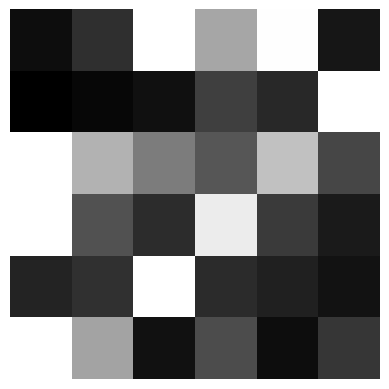

In [ ]:
image_size = task1_train_img.shape[1]

# take a random image
img_1 = np.array(task1_train_img.iloc[1])
size = int(math.sqrt(img_1.shape[0]))

# Reshape the flattened array into a square image
square_img = img_1.reshape((size, size))

# Display the image using Matplotlib
plt.imshow(square_img, cmap='gray')  # Use 'gray' for grayscale images
plt.axis('off')  # Hide axes
plt.show()

As seen above, the given data corresponds to extracted 36 features from a pre-existing dataset.

In [ ]:
task1_train_label.shape

(2000, 1)

In [ ]:
type(task1_train_label.iloc[0, 0])

numpy.float64

In [ ]:
print(f"The labes of the images are {task1_train_label[0].unique()}")

The labes of the images are [0. 1. 2. 3. 4.]


### Check mean, variance per column

### Neural Network

In [ ]:
class Neural_Net(nn.Module):
  def __init__(self):
    # initialize the parent class
    super(Neural_Net, self).__init__()
    self.fc1 = nn.Linear(36, 20)
    self.fc2 = nn.Linear(20, 10)
    self.fc3 = nn.Linear(10, 5)
    # self.optim = optim

  def forward(self, input):
    # s1 has size 20
    s1 = self.fc1(input)
    s1 = torch.tanh(s1)

    # s2 has size 10
    s2 = self.fc2(s1)
    s2 = torch.tanh(s2)

    # s3 has output 5 - are the logits of the output classes
    s3 = self.fc3(s2)

    # output = F.softmax(s3, dim = 0)
    return s3

In [ ]:
# create a random sample to use always
original_nn = Neural_Net()
torch.save(original_nn.state_dict(), "initial_weights.pth")

In [ ]:
# hyperparams
criterion = nn.CrossEntropyLoss()
lr = 0.01
stopping_criteria = 0.0001
max_epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Confusion Matrix Functions

In [ ]:
def confusion_matrix_train(model):
  x_train = torch.tensor(task1_train_img.values, dtype=torch.float32)  # Use .values to extract raw data
  y_train_true = torch.tensor(task1_train_label.values, dtype=torch.float32)  # Use .values to extract raw data

  # Assuming you have a trained model and training datas
  y_train_pred = model.forward(x_train).detach()  # Model predictions

  # If the output is probability scores, convert to class labels
  y_train_pred = np.argmax(y_train_pred, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_train_true, y_train_pred)

  # Compute accuracy from the confusion matrix
  accuracy = np.trace(cm) / np.sum(cm)
  print(f"Training Accuracy: {accuracy:.4f}")

  # Plot confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train_true), yticklabels=np.unique(y_train_true))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix (Train Data)")
  plt.show()

In [ ]:
def confusion_matrix_test(model):
  x_test = torch.tensor(task1_test_img.values, dtype=torch.float32)  # Use .values to extract raw data
  y_test_true = torch.tensor(task1_test_label.values, dtype=torch.float32)  # Use .values to extract raw data

  # Assuming you have a trained model and training datas
  y_test_pred = model.forward(x_test).detach()  # Model predictions

  # If the output is probability scores, convert to class labels
  y_test_pred = np.argmax(y_test_pred, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_test_true, y_test_pred)

  # Compute accuracy from the confusion matrix
  accuracy = np.trace(cm) / np.sum(cm)
  print(f"Testing Accuracy: {accuracy:.4f}")

  # Plot confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_true), yticklabels=np.unique(y_test_true))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix (Test Data)")
  plt.show()

In [ ]:
def confusion_matrix_val(model):
  x_val = torch.tensor(task1_val_img.values, dtype=torch.float32)  # Use .values to extract raw data
  y_val_true = torch.tensor(task1_val_label.values, dtype=torch.float32)  # Use .values to extract raw data

  # Assuming you have a trained model and training datas
  y_val_pred = model.forward(x_val).detach()  # Model predictions

  # If the output is probability scores, convert to class labels
  y_val_pred = np.argmax(y_val_pred, axis=1)

  # Compute confusion matrix
  cm = confusion_matrix(y_val_true, y_val_pred)

  # Compute accuracy from the confusion matrix
  accuracy = np.trace(cm) / np.sum(cm)
  print(f"Validation Accuracy: {accuracy:.4f}")

  # Plot confusion matrix
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val_true), yticklabels=np.unique(y_val_true))
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix (Validation Data)")
  plt.show()

## Delta Rule

In [ ]:
# Create a new instance of MyNN
nn1 = Neural_Net().to(device)  # Move model to GPU

# Load the saved weights into nn1
nn1.load_state_dict(torch.load("initial_weights.pth", map_location=device))

# Define optimizer
optimizer = optim.SGD(nn1.parameters(), lr=lr)

<ipython-input-16-78331033e3dc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn1.load_state_dict(torch.load("initial_weights.pth", map_location=device))


In [ ]:
loss_arr_delta = []
epoch_delta = 0
prev_epoch_avg_loss_delta = 0
current_epoch_avg_loss_delta = 10
change = abs(current_epoch_avg_loss_delta - prev_epoch_avg_loss_delta)

# Move model to device
nn1.to(device)
criterion = criterion.to(device)

while change > stopping_criteria and epoch_delta < max_epochs:
    indices = list(range(task1_train_img.shape[0]))
    random.shuffle(indices)
    epoch_loss = 0

    for idx in indices:
        # Preprocessing input
        input = task1_train_img.iloc[idx]
        input_tensor = torch.tensor(input.values, dtype=torch.float32, device=device).unsqueeze(0)

        # Preprocessing label
        label = torch.tensor(int(task1_train_label.iloc[idx][0]), dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        output = nn1(input_tensor)
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_arr_delta.append(epoch_loss / len(indices))
    prev_epoch_avg_loss_delta = current_epoch_avg_loss_delta
    current_epoch_avg_loss_delta = epoch_loss / len(indices)
    change = abs(current_epoch_avg_loss_delta - prev_epoch_avg_loss_delta)

    if epoch_delta % 10 == 0:
        print(f"Epoch {epoch_delta+1}, Loss: {loss_arr_delta[-1]:.4f}")

    epoch_delta += 1

Epoch 1, Loss: 1.6124
Epoch 11, Loss: 1.3077
Epoch 21, Loss: 1.2495


In [ ]:
print(f"{epoch_delta} number of epochs were taken")
print(f"Final loss was {current_epoch_avg_loss_delta}")

24 number of epochs were taken
Final loss was 1.2457873525330796


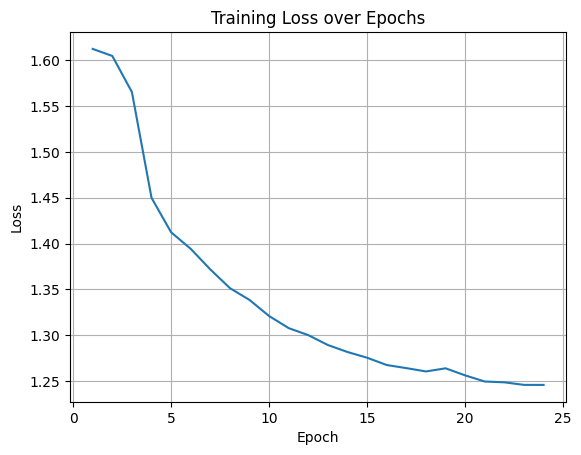

In [ ]:
plt.plot(range(1, len(loss_arr_delta) + 1), loss_arr_delta, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training Accuracy: 0.4855


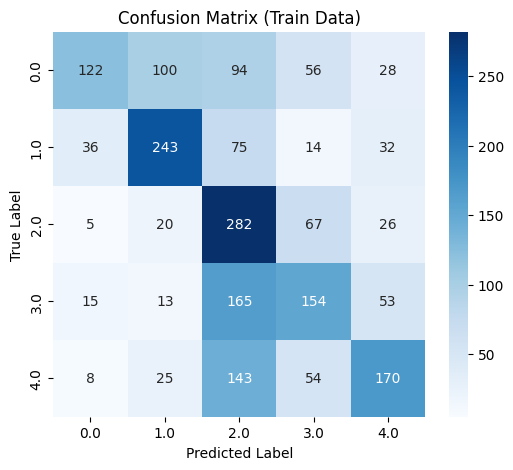

In [ ]:
confusion_matrix_train(nn1)

Testing Accuracy: 0.4040


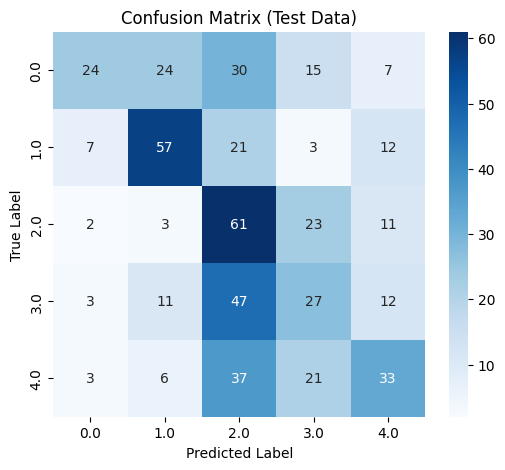

In [ ]:
confusion_matrix_test(nn1)

Validation Accuracy: 0.4180


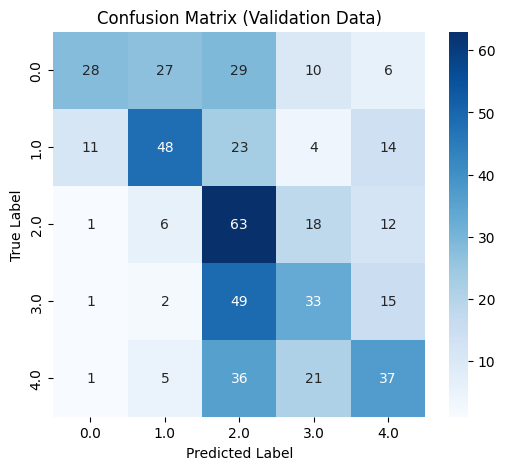

In [ ]:
confusion_matrix_val(nn1)

## Generalized Delta Rule

In [ ]:
# Create a new instance of MyNN and move it to GPU
nn2 = Neural_Net().to(device)

# Load the saved weights into nn2
nn2.load_state_dict(torch.load("initial_weights.pth", map_location=device))

# Define optimizer
optimizer = optim.SGD(nn2.parameters(), lr=lr, momentum=0.1)

<ipython-input-23-9f8c2fee57e2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn2.load_state_dict(torch.load("initial_weights.pth", map_location=device))


In [ ]:
loss_arr_gen = []
epoch_gen = 0
prev_epoch_avg_loss_gen = 0
current_epoch_avg_loss_gen = 10
change = abs(current_epoch_avg_loss_gen - prev_epoch_avg_loss_gen)

# Move model to GPU
nn2.to(device)

while change > stopping_criteria and epoch_gen < max_epochs:
    indices = list(range(task1_train_img.shape[0]))
    random.shuffle(indices)
    epoch_loss = 0

    for idx in indices:
        # Preprocessing input
        input = task1_train_img.iloc[idx]
        input_tensor = torch.tensor(input.values, dtype=torch.float32, device=device).unsqueeze(0)

        # Preprocessing label
        label = torch.tensor(int(task1_train_label.iloc[idx][0]), dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        output = nn2(input_tensor)
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_arr_gen.append(epoch_loss / len(indices))
    prev_epoch_avg_loss_gen = current_epoch_avg_loss_gen
    current_epoch_avg_loss_gen = epoch_loss / len(indices)
    change = abs(current_epoch_avg_loss_gen - prev_epoch_avg_loss_gen)

    if epoch_gen % 10 == 0:
        print(f"Epoch {epoch_gen+1}, Loss: {loss_arr_gen[-1]:.4f}")

    epoch_gen += 1

Epoch 1, Loss: 1.6116
Epoch 11, Loss: 1.3015
Epoch 21, Loss: 1.2489
Epoch 31, Loss: 1.2204
Epoch 41, Loss: 1.1860
Epoch 51, Loss: 1.1709
Epoch 61, Loss: 1.1561
Epoch 71, Loss: 1.1415
Epoch 81, Loss: 1.1330
Epoch 91, Loss: 1.1196
Epoch 101, Loss: 1.1100
Epoch 111, Loss: 1.0880
Epoch 121, Loss: 1.0712
Epoch 131, Loss: 1.0686
Epoch 141, Loss: 1.0514


In [ ]:
print(f"{epoch_gen} number of epochs were taken")
print(f"Final loss was {current_epoch_avg_loss_gen}")

146 number of epochs were taken
Final loss was 1.0425478294742205


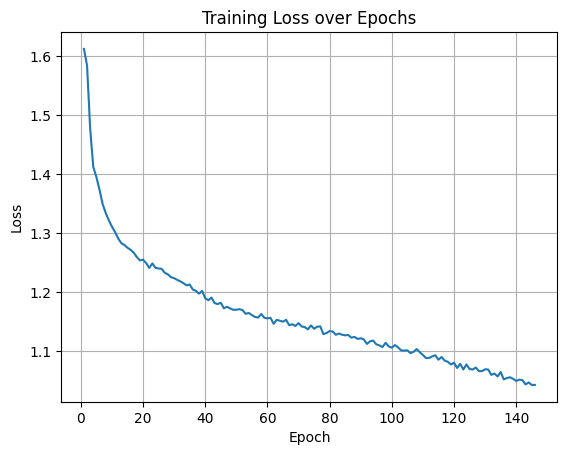

In [ ]:
plt.plot(range(1, len(loss_arr_gen) + 1), loss_arr_gen, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training Accuracy: 0.5985


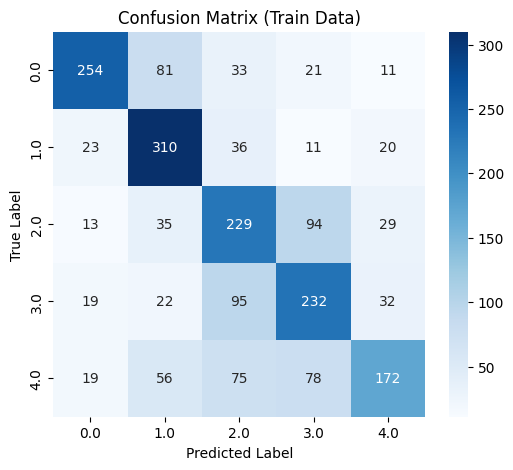

In [ ]:
confusion_matrix_train(nn2)

Testing Accuracy: 0.4520


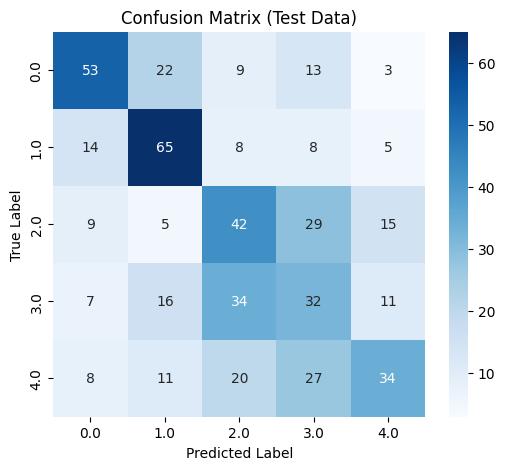

In [ ]:
confusion_matrix_test(nn2)

Validation Accuracy: 0.4860


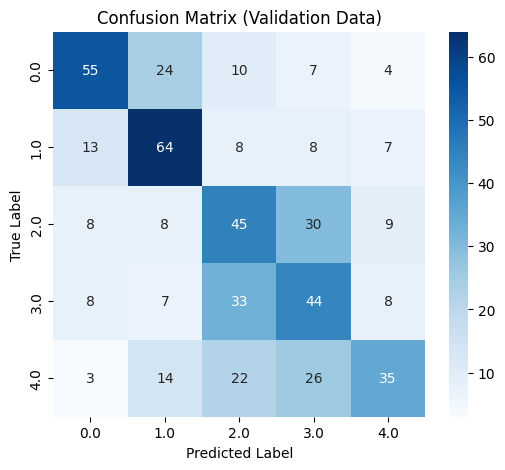

In [ ]:
confusion_matrix_val(nn2)

## AdaGrad

In [ ]:
# Create a new instance of MyNN and move it to GPU
nn3 = Neural_Net().to(device)

# Load the saved weights into nn3
nn3.load_state_dict(torch.load("initial_weights.pth", map_location=device))

# Define optimizer
optimizer = optim.Adagrad(nn3.parameters(), lr=lr)

<ipython-input-30-7c962bb6208b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn3.load_state_dict(torch.load("initial_weights.pth", map_location=device))


In [ ]:
loss_arr_ada = []
epoch_ada = 0
prev_epoch_avg_loss_ada = 0
current_epoch_avg_loss_ada = 10
change = abs(current_epoch_avg_loss_ada - prev_epoch_avg_loss_ada)

# Move model to GPU
nn3.to(device)

while change > stopping_criteria and epoch_ada < max_epochs:
    indices = list(range(task1_train_img.shape[0]))
    random.shuffle(indices)
    epoch_loss = 0

    for idx in indices:
        # Preprocessing input
        input = task1_train_img.iloc[idx]
        input_tensor = torch.tensor(input.values, dtype=torch.float32, device=device).unsqueeze(0)

        # Preprocessing label
        label = torch.tensor(int(task1_train_label.iloc[idx][0]), dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        output = nn3(input_tensor)
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_arr_ada.append(epoch_loss / len(indices))
    prev_epoch_avg_loss_ada = current_epoch_avg_loss_ada
    current_epoch_avg_loss_ada = epoch_loss / len(indices)
    change = abs(current_epoch_avg_loss_ada - prev_epoch_avg_loss_ada)

    if epoch_ada % 10 == 0:
        print(f"Epoch {epoch_ada+1}, Loss: {loss_arr_ada[-1]:.4f}")

    epoch_ada += 1

Epoch 1, Loss: 1.5847
Epoch 11, Loss: 1.3615
Epoch 21, Loss: 1.3264
Epoch 31, Loss: 1.3098
Epoch 41, Loss: 1.2990
Epoch 51, Loss: 1.2911
Epoch 61, Loss: 1.2848
Epoch 71, Loss: 1.2797


In [ ]:
print(f"{epoch_ada} number of epochs were taken")
print(f"Final loss was {current_epoch_avg_loss_ada}")

79 number of epochs were taken
Final loss was 1.2763179570175707


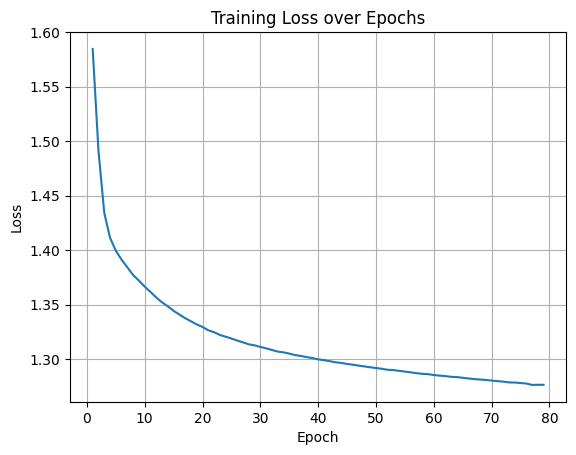

In [ ]:
plt.plot(range(1, len(loss_arr_ada) + 1), loss_arr_ada, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training Accuracy: 0.4655


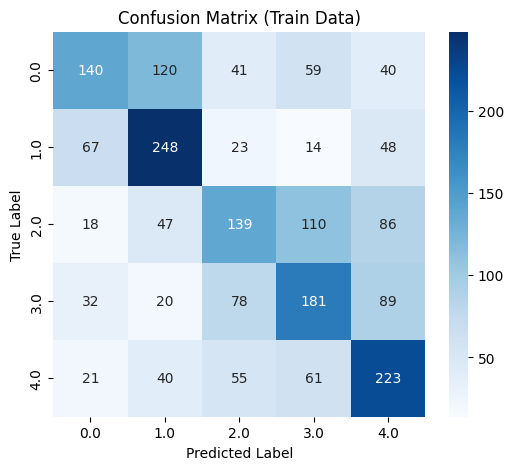

In [ ]:
confusion_matrix_train(nn3)

Testing Accuracy: 0.4140


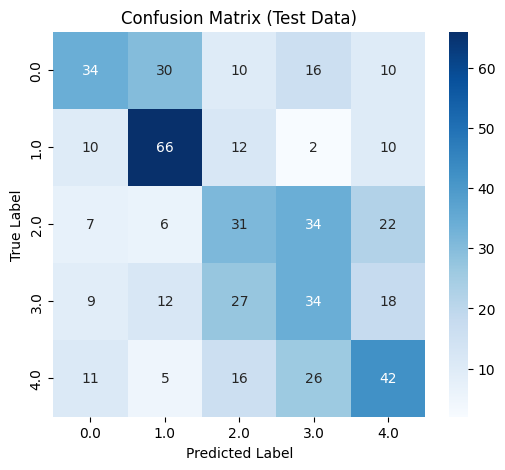

In [ ]:
confusion_matrix_test(nn3)

Validation Accuracy: 0.4020


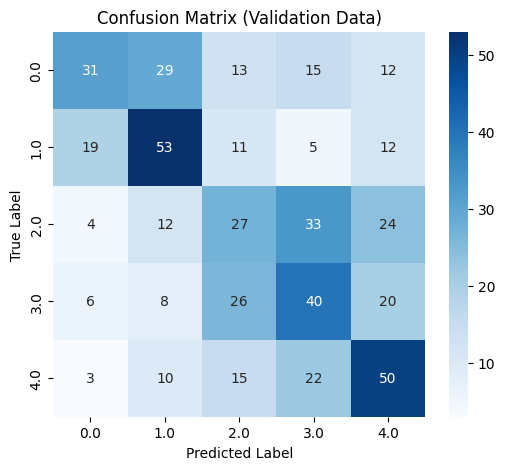

In [ ]:
confusion_matrix_val(nn3)

## RMSProp

In [ ]:
# Create a new instance of MyNN and move it to GPU
nn4 = Neural_Net().to(device)

# Load the saved weights into nn4
nn4.load_state_dict(torch.load("initial_weights.pth", map_location=device))

# Define optimizer
optimizer = optim.RMSprop(nn4.parameters(), lr=lr)

<ipython-input-37-81f909f12aea>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn4.load_state_dict(torch.load("initial_weights.pth", map_location=device))


In [ ]:
loss_arr_rms = []
epoch_rms = 0
prev_epoch_avg_loss_rms = 0
current_epoch_avg_loss_rms = 10
change = abs(current_epoch_avg_loss_rms - prev_epoch_avg_loss_rms)

# Move model to GPU
nn4.to(device)

while change > stopping_criteria and epoch_rms < max_epochs:
    indices = list(range(task1_train_img.shape[0]))
    random.shuffle(indices)
    epoch_loss = 0

    for idx in indices:
        # Preprocessing input
        input = task1_train_img.iloc[idx]
        input_tensor = torch.tensor(input.values, dtype=torch.float32, device=device).unsqueeze(0)

        # Preprocessing label
        label = torch.tensor(int(task1_train_label.iloc[idx][0]), dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        output = nn4(input_tensor)
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_arr_rms.append(epoch_loss / len(indices))
    prev_epoch_avg_loss_rms = current_epoch_avg_loss_rms
    current_epoch_avg_loss_rms = epoch_loss / len(indices)
    change = abs(current_epoch_avg_loss_rms - prev_epoch_avg_loss_rms)

    if epoch_rms % 10 == 0:
        print(f"Epoch {epoch_rms+1}, Loss: {loss_arr_rms[-1]:.4f}")

    epoch_rms += 1

Epoch 1, Loss: 1.4862
Epoch 11, Loss: 1.2922
Epoch 21, Loss: 1.2729
Epoch 31, Loss: 1.2181
Epoch 41, Loss: 1.2079
Epoch 51, Loss: 1.1652
Epoch 61, Loss: 1.1328
Epoch 71, Loss: 1.1302
Epoch 81, Loss: 1.1123
Epoch 91, Loss: 1.0944
Epoch 101, Loss: 1.0734
Epoch 111, Loss: 1.0266
Epoch 121, Loss: 1.0301
Epoch 131, Loss: 1.0302
Epoch 141, Loss: 0.9746
Epoch 151, Loss: 0.9877
Epoch 161, Loss: 0.9751
Epoch 171, Loss: 0.9396


In [ ]:
print(f"{epoch_rms} number of epochs were taken")
print(f"Final loss was {current_epoch_avg_loss_rms}")

176 number of epochs were taken
Final loss was 0.9620092073937995


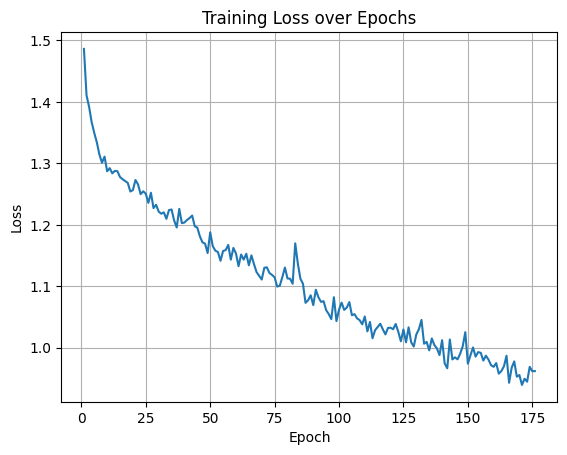

In [ ]:
plt.plot(range(1, len(loss_arr_rms) + 1), loss_arr_rms, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training Accuracy: 0.6335


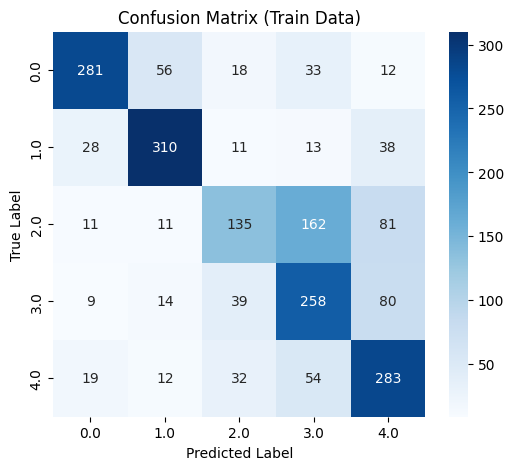

In [ ]:
confusion_matrix_train(nn4)

Testing Accuracy: 0.4020


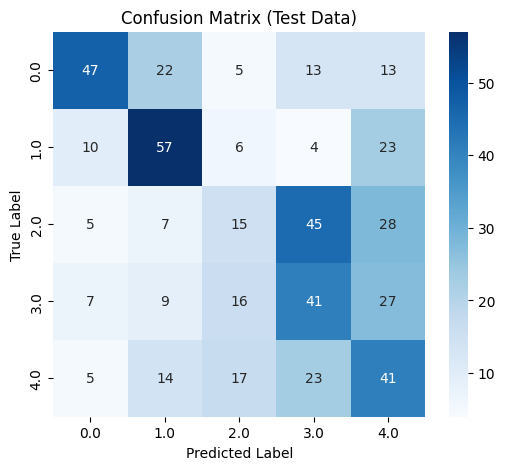

In [ ]:
confusion_matrix_test(nn4)

Validation Accuracy: 0.4140


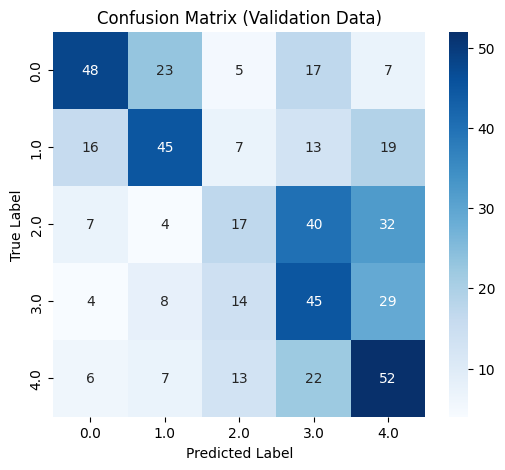

In [ ]:
confusion_matrix_val(nn4)

## Adam

In [ ]:
# Create a new instance of MyNN and move it to GPU
nn5 = Neural_Net().to(device)

# Load the saved weights into nn5
nn5.load_state_dict(torch.load("initial_weights.pth", map_location=device))

# Define optimizer
optimizer = optim.Adam(nn5.parameters(), lr=lr)

<ipython-input-44-5016b37366d9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn5.load_state_dict(torch.load("initial_weights.pth", map_location=device))


In [ ]:
# Move model to GPU
nn5.to(device)

loss_arr_adam = []
epoch_adam = 0
prev_epoch_avg_loss_adam = 0
current_epoch_avg_loss_adam = 10
change = abs(current_epoch_avg_loss_adam - prev_epoch_avg_loss_adam)

while change > stopping_criteria and epoch_adam < max_epochs:
    indices = list(range(task1_train_img.shape[0]))
    random.shuffle(indices)
    epoch_loss = 0

    for idx in indices:
        # Preprocessing input
        input = task1_train_img.iloc[idx]
        input_tensor = torch.tensor(input.values, dtype=torch.float32, device=device).unsqueeze(0)

        # Preprocessing label
        label = torch.tensor(int(task1_train_label.iloc[idx][0]), dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        output = nn5(input_tensor)
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_arr_adam.append(epoch_loss / len(indices))
    prev_epoch_avg_loss_adam = current_epoch_avg_loss_adam
    current_epoch_avg_loss_adam = epoch_loss / len(indices)
    change = abs(current_epoch_avg_loss_adam - prev_epoch_avg_loss_adam)

    if epoch_adam % 10 == 0:
        print(f"Epoch {epoch_adam+1}, Loss: {loss_arr_adam[-1]:.4f}")

    epoch_adam += 1

Epoch 1, Loss: 1.4881
Epoch 11, Loss: 1.3315
Epoch 21, Loss: 1.3475
Epoch 31, Loss: 1.2677
Epoch 41, Loss: 1.2570
Epoch 51, Loss: 1.2132
Epoch 61, Loss: 1.2052


In [ ]:
print(f"{epoch_adam} number of epochs were taken")
print(f"Final loss was {current_epoch_avg_loss_adam}")

64 number of epochs were taken
Final loss was 1.209882692361716


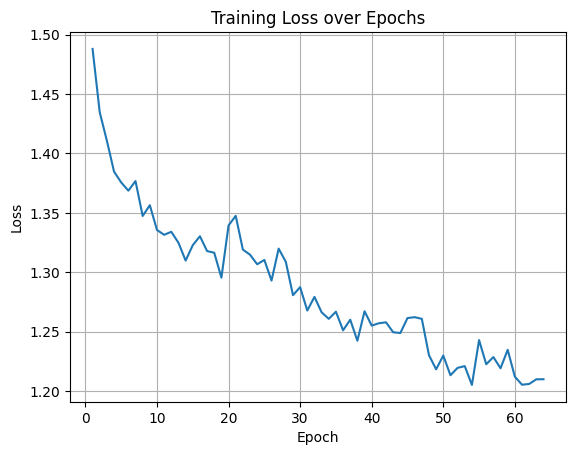

In [ ]:
plt.plot(range(1, len(loss_arr_adam) + 1), loss_arr_adam, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training Accuracy: 0.4975


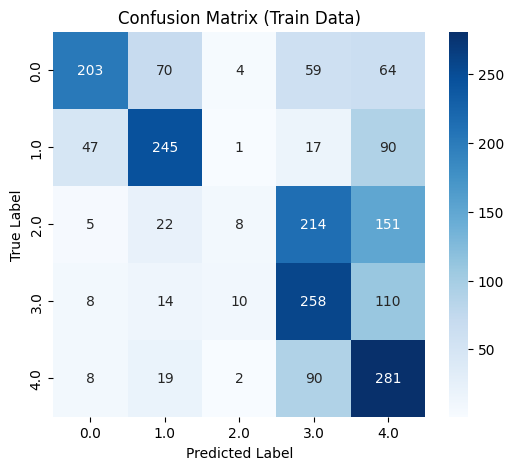

In [ ]:
confusion_matrix_train(nn5)

Testing Accuracy: 0.4260


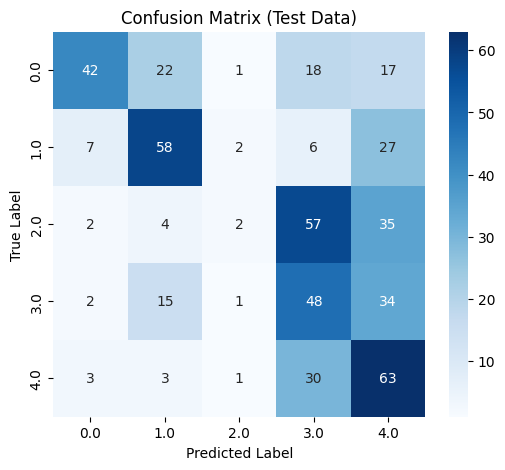

In [ ]:
confusion_matrix_test(nn5)

Validation Accuracy: 0.3880


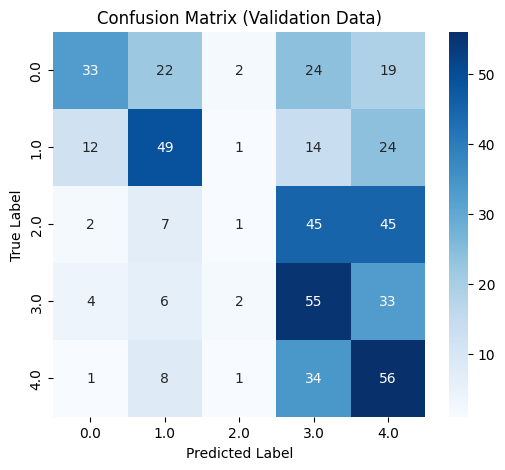

In [ ]:
confusion_matrix_val(nn5)

# Conclusions

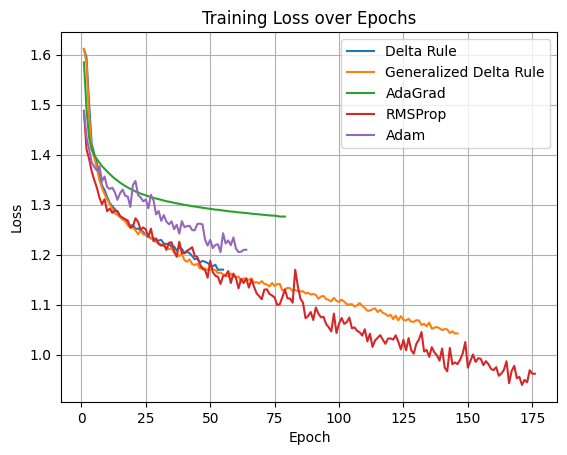

In [ ]:
plt.plot(range(1, len(loss_arr_delta) + 1), loss_arr_delta, linestyle='-', label = 'Delta Rule')
plt.plot(range(1, len(loss_arr_gen) + 1), loss_arr_gen, linestyle='-', label = 'Generalized Delta Rule')
plt.plot(range(1, len(loss_arr_ada) + 1), loss_arr_ada, linestyle='-', label = 'AdaGrad')
plt.plot(range(1, len(loss_arr_rms) + 1), loss_arr_rms, linestyle='-', label = 'RMSProp')
plt.plot(range(1, len(loss_arr_adam) + 1), loss_arr_adam, linestyle='-', label = 'Adam')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Delta Rule took {epoch_delta} number of epochs, and reached loss of {current_epoch_avg_loss_delta}")
print(f"Generalized Delta Rule took {epoch_gen} number of epochs, and reached loss of {current_epoch_avg_loss_gen}")
print(f"AdaGrad Rule took {epoch_ada} number of epochs, and reached loss of {current_epoch_avg_loss_ada}")
print(f"RMSProp Rule took {epoch_rms} number of epochs, and reached loss of {current_epoch_avg_loss_rms}")
print(f"AdaM Rule took {epoch_adam} number of epochs, and reached loss of {current_epoch_avg_loss_adam}")

Delta Rule took 55 number of epochs, and reached loss of 1.1701859566161874
Generalized Delta Rule took 146 number of epochs, and reached loss of 1.0425478294742205
AdaGrad Rule took 79 number of epochs, and reached loss of 1.2763179570175707
RMSProp Rule took 176 number of epochs, and reached loss of 0.9620092073937995
AdaM Rule took 64 number of epochs, and reached loss of 1.209882692361716
